# CLIP visual recognition service

In [1]:
import torch
import clip
from PIL import Image

import time

In [85]:
### PARAMS

# Not likely to change during course of interaction
description_dict = {
    'person': {
        # 'attributes': ['gender','age'],
        # 'states': ['role', 'activity', 'emotion', 'focus'],
        'attributes': {
            'gender': {
                'labels': ['unknown','male','female','nonbinary'],
                'descriptions': ['a person of unknown gender','a male person','a female person','a nonbinary person']
            },
            'age': {
                'labels': ['unknown','baby','toddler','child','young_adult','adult','elder'],
                'descriptions': ['a person of unknown age','a baby','a toddler','a child','a young adult','an adult','an elderly adult']
            }
        },
        'states': {
            'role': {
                'labels': ['unknown','civilian','military'],
                'descriptions': ['a person', 'a civilian person','a person in the military']
                
            },
            'movement': {
                'labels': ['unknown','sitting', 'standing','walking','running'],
                'descriptions': ['a person','a person sitting down', 'a person standing', 'a person walking','a person running']
            },
            'emotion': {
                'labels': ['unknown','happy','sad','angry','neutral'],
                'descriptions': ['a person with unknown emotion','a happy person','a sad person','an angry person','a person with neutral emotion']
                
            }
        }   
    }
}

In [86]:
print(description_dict)

{'person': {'attributes': {'gender': {'labels': ['unknown', 'male', 'female', 'nonbinary'], 'descriptions': ['a person of unknown gender', 'a male person', 'a female person', 'a nonbinary person']}, 'age': {'labels': ['unknown', 'baby', 'toddler', 'child', 'young_adult', 'adult', 'elder'], 'descriptions': ['a person of unknown age', 'a baby', 'a toddler', 'a child', 'a young adult', 'an adult', 'an elderly adult']}}, 'states': {'role': {'labels': ['unknown', 'civilian', 'military'], 'descriptions': ['a person', 'a civilian person', 'a person in the military']}, 'movement': {'labels': ['unknown', 'sitting', 'standing', 'walking', 'running'], 'descriptions': ['a person', 'a person sitting down', 'a person standing', 'a person walking', 'a person running']}, 'emotion': {'labels': ['unknown', 'happy', 'sad', 'angry', 'neutral'], 'descriptions': ['a person with unknown emotion', 'a happy person', 'a sad person', 'an angry person', 'a person with neutral emotion']}}}}


In [87]:
### INITIALIZATION
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [88]:
### COMPUTE TEXT TOKENS AND FEATURES
for label in description_dict.keys():
    for attribute in description_dict[label]['attributes'].keys():
        description_dict[label]['attributes'][attribute]['text_tokens'] = clip.tokenize(description_dict[label]['attributes'][attribute]['descriptions']).to(device)
        description_dict[label]['attributes'][attribute]['text_features'] = model.encode_text(description_dict[label]['attributes'][attribute]['text_tokens'])
    
    for state in description_dict[label]['states'].keys():
        description_dict[label]['states'][state]['text_tokens'] = clip.tokenize(description_dict[label]['states'][state]['descriptions']).to(device)
        description_dict[label]['states'][state]['text_features'] = model.encode_text(description_dict[label]['states'][state]['text_tokens'])    

In [89]:
start = time.time()

### LOAD IMAGE AND COMPUTE EMBEDDINGS
label = 'person'


if label in description_dict.keys():

    image = preprocess(Image.open("../../test_img_from_cv_crop.jpg")).unsqueeze(0).to(device)
    
    with torch.no_grad():
        image_features = model.encode_image(image)
    
    
        for attribute in description_dict[label]['attributes'].keys():
            description_dict[label]['attributes'][attribute]['text_features'] = model.encode_text(description_dict[label]['attributes'][attribute]['text_tokens'])
            logits_per_image, logits_per_text = model(image, description_dict[label]['attributes'][attribute]['text_tokens'])
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            
            print("Labels:", description_dict[label]['attributes'][attribute]['labels'])
            print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
            
        for state in description_dict[label]['states'].keys():
            description_dict[label]['attributes'][attribute]['text_features'] = model.encode_text(description_dict[label]['attributes'][attribute]['text_tokens'])
            logits_per_image, logits_per_text = model(image, description_dict[label]['states'][state]['text_tokens'])
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            
            print("Labels:", description_dict[label]['states'][state]['labels'])
            print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
else:
    print(f"No information for class {label}")

print(time.time() - start)

Labels: ['unknown', 'male', 'female', 'nonbinary']
Label probs: [[0.2212  0.4539  0.03186 0.293  ]]
Labels: ['unknown', 'baby', 'toddler', 'child', 'young_adult', 'adult', 'elder']
Label probs: [[0.0816  0.01418 0.03146 0.04233 0.1958  0.3833  0.2515 ]]
Labels: ['unknown', 'civilian', 'military']
Label probs: [[0.0737 0.528  0.3984]]
Labels: ['unknown', 'sitting', 'standing', 'walking', 'running']
Label probs: [[0.037   0.3794  0.43    0.05136 0.1021 ]]
Labels: ['unknown', 'happy', 'sad', 'angry', 'neutral']
Label probs: [[0.03845 0.703   0.06854 0.0471  0.1428 ]]
0.09433221817016602


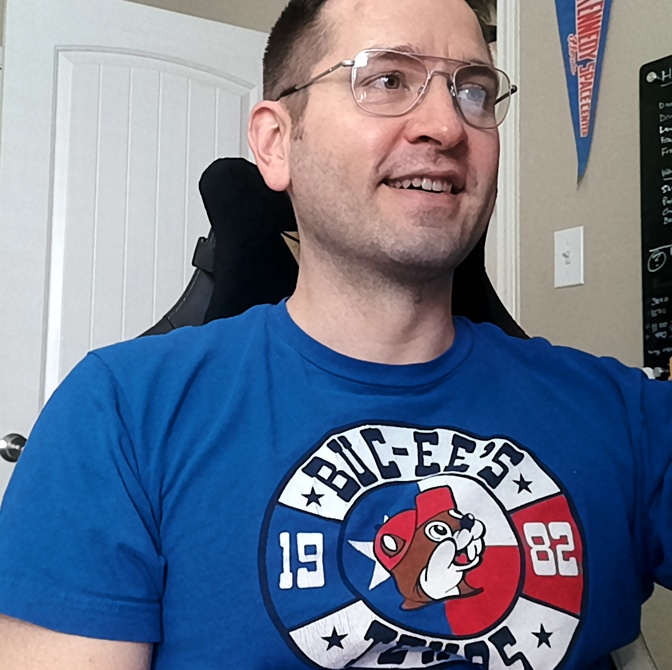

In [79]:
Image.open("../../test_img_from_cv_crop.jpg")

In [144]:
import time

In [135]:
import torch
import clip
from PIL import Image

In [136]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [163]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:19<00:00, 18.4MiB/s]


In [221]:
image = preprocess(Image.open("../../test_img_from_cv_crop.jpg")).unsqueeze(0).to(device)
scene_text = clip.tokenize(["an indoor scene", "an outdoor scene", "a picture of transportation"]).to(device)

clothing_text = clip.tokenize(["a person wearing casual clothing", "a person wearing formal clothing"]).to(device)

emote_text = clip.tokenize(["a happy person", "a neutral person", "an angry person"]).to(device)
print(emote_text)

tensor([[49406,   320,   900,  2533, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320, 17011,  2533, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [222]:
start = time.time()
with torch.no_grad():
    scene_text_features = model.encode_text(scene_text)
    clothing_text_features = model.encode_text(clothing_text)
    emote_text_features = model.encode_text(emote_text)
    
    image_features = model.encode_image(image)
    
    logits_per_image, logits_per_text = model(image, emote_text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
stop = time.time()



print("Label probs:", probs)
print(stop - start)

Label probs: [[0.919   0.02774 0.05347]]
0.055628061294555664


# GTSAM fusion - multiple measurements

In [7]:
import gtsam

roles = ["role_1","role_2","role_3"]
obs = ["o1","o2","o3"]
id = 113
n_obs = 0
role_symbol = gtsam.Symbol('r',id)
obs_symbol = gtsam.Symbol('o',id)

# Prior
role_prior = gtsam.DiscreteDistribution((role_symbol.key(),len(roles)),".75/.15/.1")

# Measurement likelihood
p_det_role = gtsam.DiscreteConditional((obs_symbol.key(),len(obs)), [(role_symbol.key(),len(roles))], "2/1/1 1/2/1 1/2/3")

# Measurement distribution
p_obs = gtsam.DecisionTreeFactor((obs_symbol.key(),len(obs)),".45 .55 .0")

In [14]:
obs_received = [2,2,2,2,1,0]
factors = []

post = role_prior

for idx, ob in enumerate(obs_received):
    print("Index: %s, observation %s" % (idx,ob))
    factor = p_det_role.likelihood(ob)
    factors.append(factor)

    post = gtsam.DiscreteDistribution(factor*post)

    print("BAYES: %s" % post)

Index: 0, observation 2
BAYES: Discrete Prior
 P( r113 ):
 Choice(r113) 
 0 Leaf 0.68181818
 1 Leaf 0.13636364
 2 Leaf 0.18181818


Index: 1, observation 2
BAYES: Discrete Prior
 P( r113 ):
 Choice(r113) 
 0 Leaf 0.57692308
 1 Leaf 0.11538462
 2 Leaf 0.30769231


Index: 2, observation 2
BAYES: Discrete Prior
 P( r113 ):
 Choice(r113) 
 0 Leaf 0.44117647
 1 Leaf 0.088235294
 2 Leaf 0.47058824


Index: 3, observation 2
BAYES: Discrete Prior
 P( r113 ):
 Choice(r113) 
 0 Leaf  0.3
 1 Leaf 0.06
 2 Leaf 0.64


Index: 4, observation 1
BAYES: Discrete Prior
 P( r113 ):
 Choice(r113) 
 0 Leaf 0.23560209
 1 Leaf 0.094240838
 2 Leaf 0.67015707


Index: 5, observation 0
BAYES: Discrete Prior
 P( r113 ):
 Choice(r113) 
 0 Leaf 0.46551724
 1 Leaf 0.093103448
 2 Leaf 0.44137931




In [17]:
gtsam.DiscreteDistribution(factors[3]*factors[2]*factors[4]*factors[1]*factors[0]*role_prior)

r113,value
0,0.235602
1,0.0942408
2,0.670157


# Audio dev

In [19]:
import numpy as np
import sentencepiece as spm
import torch
import torchaudio
import torchvision
from torchaudio.io import StreamReader
import torch.multiprocessing as mp

In [73]:
def stream(q, format, src, segment_length, sample_rate):
    
    print("Building StreamReader...")
    streamer = torchaudio.io.StreamReader(src=src, format=format, option=option)
    streamer.add_basic_audio_stream(frames_per_chunk=segment_length, sample_rate=sample_rate, format="s16p", num_channels=6)

    print(streamer.get_src_stream_info(0))
    print("Streaming...")
    print()
    for (chunk_a) in streamer.stream(timeout=-1, backoff=1.0):
        q.put([chunk_a])


class ContextCacher:
    """Cache the end of input data and prepend the next input data with it.

    Args:
        segment_length (int): The size of main segment.
            If the incoming segment is shorter, then the segment is padded.
        context_length (int): The size of the context, cached and appended.
    """

    def __init__(self, segment_length: int, context_length: int):
        self.segment_length = segment_length
        self.context_length = context_length
        self.context = torch.zeros([context_length])

    def __call__(self, chunk: torch.Tensor):
        if chunk.size(0) < self.segment_length:
            chunk = torch.nn.functional.pad(chunk, (0, self.segment_length - chunk.size(0)))
        chunk_with_context = torch.cat((self.context, chunk))
        self.context = chunk[-self.context_length :]
        return chunk_with_context

class Pipeline:
    """Build inference pipeline from RNNTBundle.

    Args:
        bundle (torchaudio.pipelines.RNNTBundle): Bundle object
        beam_width (int): Beam size of beam search decoder.
    """

    def __init__(self, bundle: torchaudio.pipelines.RNNTBundle, beam_width: int = 10):
        self.bundle = bundle
        self.feature_extractor = bundle.get_streaming_feature_extractor()
        self.decoder = bundle.get_decoder()
        self.token_processor = bundle.get_token_processor()

        self.beam_width = beam_width

        self.state = None
        self.hypotheses = None

    def infer(self, segment: torch.Tensor) -> str:
        """Perform streaming inference"""
        features, length = self.feature_extractor(segment)
        self.hypotheses, self.state = self.decoder.infer(
            features, length, self.beam_width, state=self.state, hypothesis=self.hypotheses
        )
        transcript = self.token_processor(self.hypotheses[0][0], lstrip=False)
        return transcript

In [75]:
def main():
    # Parameters
    device = "alsa"
    src = "hw:4"
    n_channels = 6
    
    # Model info
    bundle=torchaudio.pipelines.EMFORMER_RNNT_BASE_LIBRISPEECH
    sample_rate = bundle.sample_rate
    segment_length = bundle.segment_length * bundle.hop_length
    context_length = bundle.right_context_length * bundle.hop_length
    pipeline = Pipeline(bundle)
    
    
    # Cache stream
    cacher = ContextCacher(segment_length, context_length)
    
    
    # Inference
    
    ctx = mp.get_context("spawn")
    
    @torch.inference_mode()
    def infer():
        while True:
            chunk = q.get()      
            segment = cacher(chunk[:, 0])
            transcript = pipeline.infer(segment)
            print(transcript, end="\r", flush=True)
    
    q = ctx.Queue()
    p = ctx.Process(target=stream, args=(q, device, src, segment_length, sample_rate))
    p.start()
    infer()
    p.join()

In [ ]:
main()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/home/jd/anaconda3/envs/marmot/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/home/jd/anaconda3/envs/marmot/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'stream' on <module '__main__' (built-in)>


In [66]:
print(sample_rate)
print("hop length: %s " % bundle.hop_length)
print("segment length: %s " % bundle.segment_length)
print("context length: %s " %bundle.right_context_length)
print(segment_length)
print(context_length)

print(streamer)

16000
hop length: 160 
segment length: 16 
context length: 4 
2560
640


In [ ]:
# Get stream


# Visualize stream?


# form beam at location (az/el/dist)


# visualize separated beam


# extract noise/common spectrum from all channels